In [1]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.3 MB/s eta 0:00:00


# Library

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.activations import swish
import efficientnet
from efficientnet.tfkeras import EfficientNetB4, EfficientNetB7
from efficientnet import tfkeras as efn
# Register the swish activation function
get_custom_objects().update({'swish': swish})

import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import cv2
import traceback
import pandas as pd
import json

# Data

In [4]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [3]:
from google.colab import userdata
from roboflow import Roboflow
rf = Roboflow(api_key=userdata.get('ROBOFLOW_API_KEY'))
project = rf.workspace("minh-sf1op").project("building-segmentaion")
version = project.version(1)
dataset = version.download("png-mask-semantic")

ModuleNotFoundError: No module named 'roboflow'

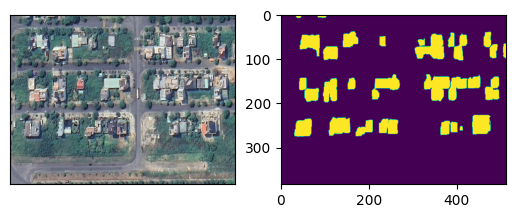

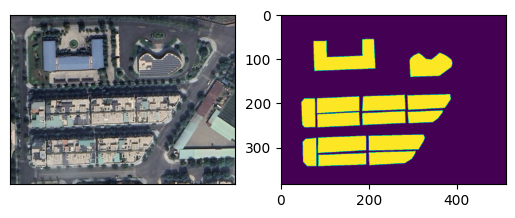

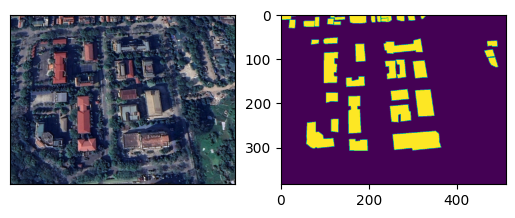

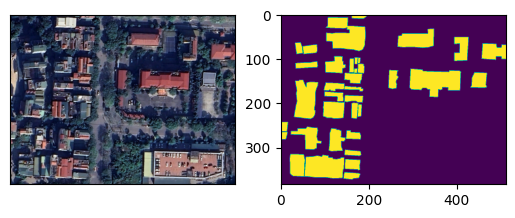

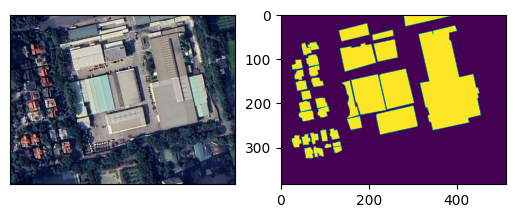

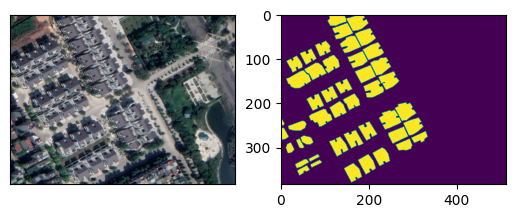

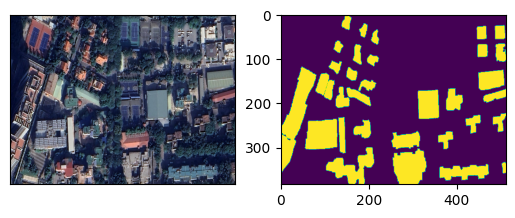

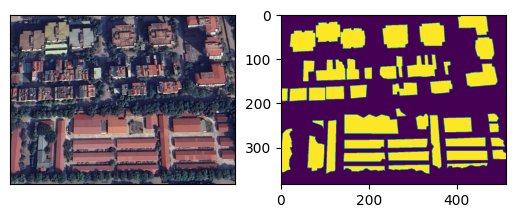

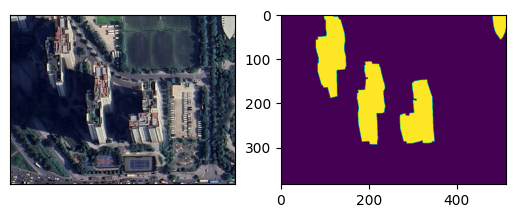

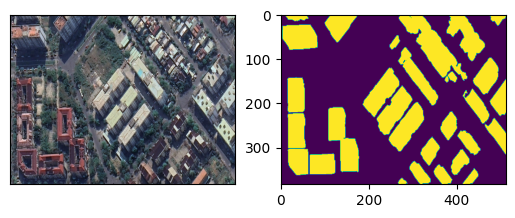

(10, 384, 512, 3)
(10, 384, 512, 1)


In [ ]:
import tensorflow as tf
import os

def load_image_and_mask(image_path, mask_path, img_size=(256, 256)):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalize to 0 or 1

    return image, mask

def take_path(folder_path):
    image_paths = []
    mask_paths = []

    # Get the list of files in the directory
    files = os.listdir(folder_path)

    # Iterate through the files by index
    for image in os.listdir(folder_path):
        if image.endswith(".jpg"):
            image_path = os.path.join(folder_path, image)
            mask_path = os.path.join(folder_path, image.replace(".jpg", "_mask.png"))

            image_paths.append(image_path)
            mask_paths.append(mask_path)


    return image_paths, mask_paths  # Return the lists instead of single paths

# Eval Funcs

## Dice Loss

In [ ]:
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)

    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - (numerator + tf.keras.backend.epsilon()) / (denominator + tf.keras.backend.epsilon())

## Jaccard Loss

In [ ]:
def jaccard_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection + K.epsilon()) / (sum_ - intersection + K.epsilon())
    return 1 - jac

# Load models

## Unet

In [ ]:
unet_model = load_model('/content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Checkpoints/unet_effnetb7.keras',custom_objects={'dice_loss': dice_loss, 'jaccard_loss': jaccard_loss,'swish': swish})
unet_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy',dice_loss,jaccard_loss])
unet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 192, 256, 48)   │          1,296 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 192, 256, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 192, 256, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 192, 256, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 192, 256, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 192, 256, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 48)       │            624 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 192, 256, 48)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 192, 256, 24)   │          1,152 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 192, 256, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization) 

 Total params: 25,735,017 (98.17 MB)

 Trainable params: 25,607,833 (97.69 MB)

 Non-trainable params: 127,184 (496.81 KB)

## Linknet

In [ ]:
linknet_model = load_model('/content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Checkpoints/linknet_effnetb7.keras',custom_objects={'dice_loss': dice_loss, 'jaccard_loss': jaccard_loss,'swish': swish})
linknet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_loss,jaccard_loss])
linknet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 192, 256, 48)   │          1,296 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 192, 256, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 192, 256, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 192, 256, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 192, 256, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 192, 256, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 48)       │            624 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 192, 256, 48)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 192, 256, 24)   │          1,152 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 192, 256, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization) 

 Total params: 21,718,217 (82.85 MB)

 Trainable params: 21,586,297 (82.35 MB)

 Non-trainable params: 131,920 (515.31 KB)

# Model Evaluate

In [ ]:
unet_eval = unet_model.evaluate(imgs, masks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.9574 - dice_loss: 0.5881 - jaccard_loss: 0.2161 - loss: 0.0917


In [ ]:
linknet_eval = linknet_model.evaluate(imgs, masks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.9590 - dice_loss: 0.5874 - jaccard_loss: 0.2002 - loss: 0.0862


In [ ]:
print('Unet model evaluation: ')
print('binary crossentropy: ', unet_eval[0])
print('accuracy: ', unet_eval[1])
print('dice loss: ', unet_eval[2])
print('jaccard loss: ', unet_eval[3])
print('\n')
print('Linknet model evaluation: ')
print('binary crossentropy: ', linknet_eval[0])
print('accuracy: ', linknet_eval[1])
print('dice loss: ', linknet_eval[2])
print('jaccard loss: ', linknet_eval[3])

Unet model evaluation: 
binary crossentropy:  0.10658613592386246
accuracy:  0.9546763300895691
dice loss:  0.602777898311615
jaccard loss:  0.24463319778442383


Linknet model evaluation: 
binary crossentropy:  0.09827979654073715
accuracy:  0.9526621699333191
dice loss:  0.6080007553100586
jaccard loss:  0.2623727321624756


1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


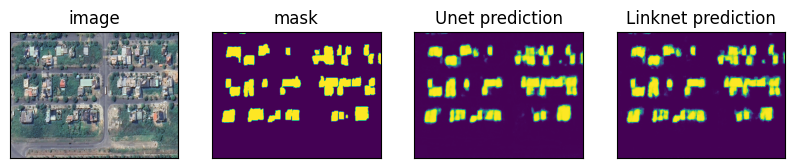

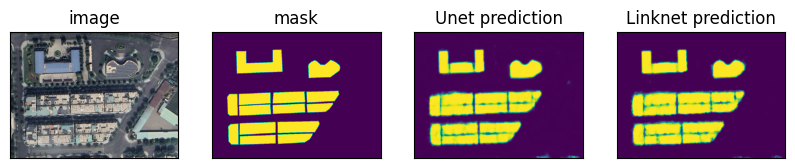

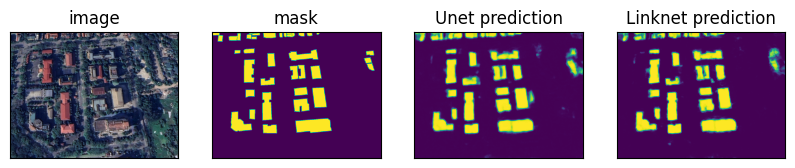

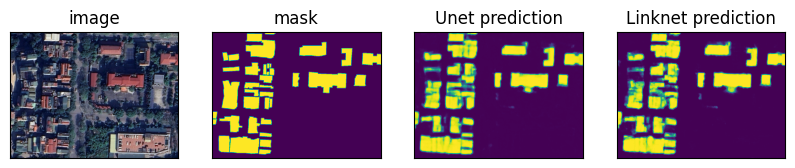

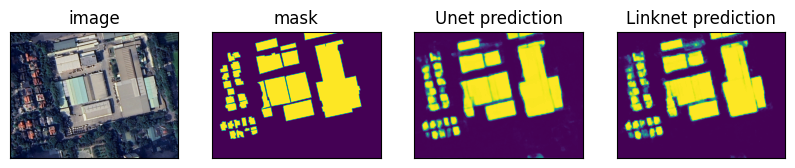

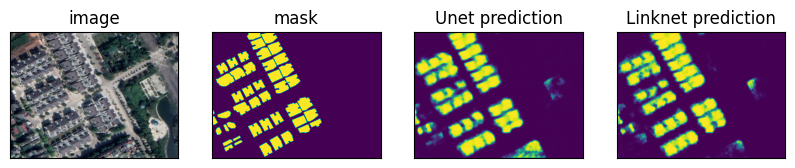

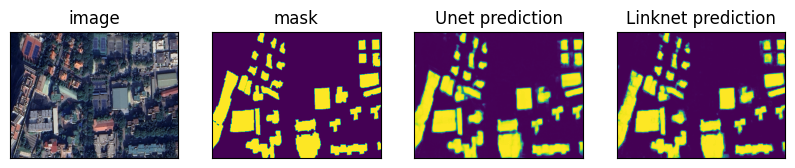

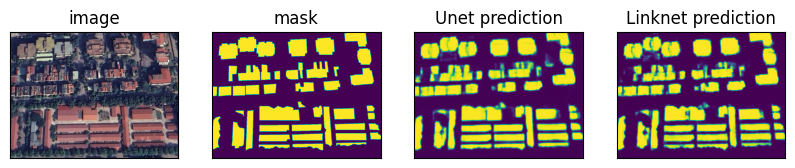

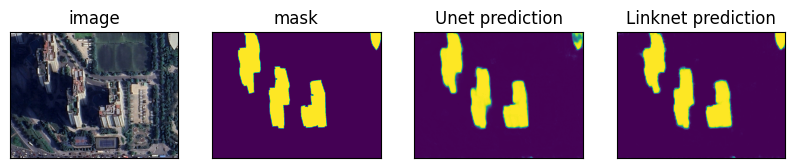

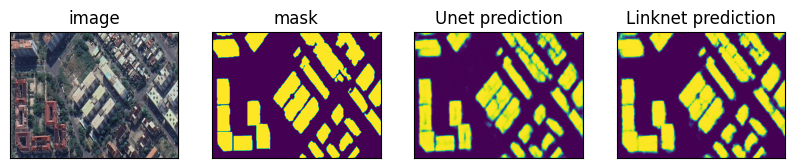

In [ ]:
preds_unet = unet_model.predict(imgs)
preds_linknet = linknet_model.predict(imgs)

for i in range(len(img_paths)):
    plt.figure(figsize=(10,5))
    plt.subplot(1,4,1)
    imgs[i]=imgs[i][...,::-1]
    plt.imshow(imgs[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('image')
    plt.subplot(1,4,2)
    plt.imshow(masks[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('mask')
    plt.subplot(1,4,3)
    plt.imshow(preds_unet[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('Unet prediction')
    plt.subplot(1,4,4)
    plt.imshow(preds_linknet[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('Linknet prediction')
    plt.show()

In [ ]:
# prompt: load imgs from /content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Data_New/Val/Final Val

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.resize(img, (512,384))
            img = img/255.0
            images.append(img)
    return images

final_val_imgs = load_images_from_folder('/content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Data_New/Val/Final Val')
final_val_imgs = np.array(final_val_imgs)
print(final_val_imgs.shape)


(13, 384, 512, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


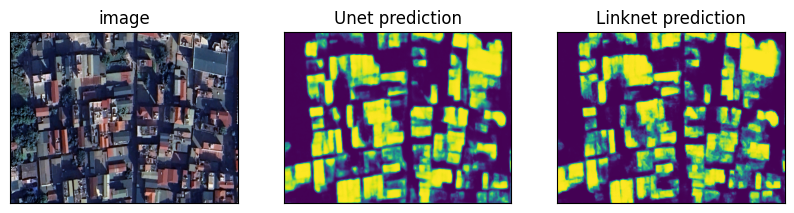

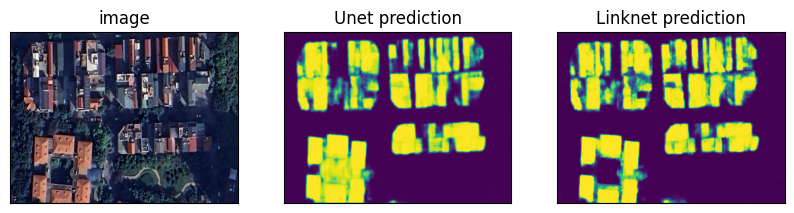

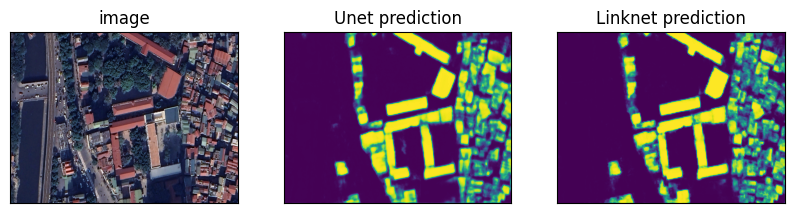

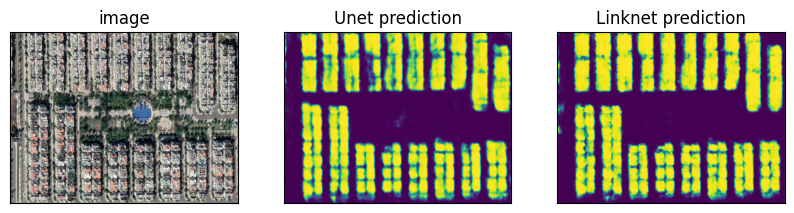

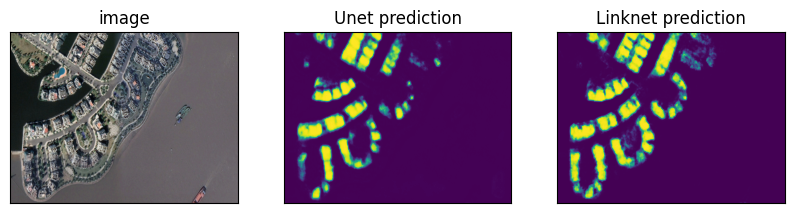

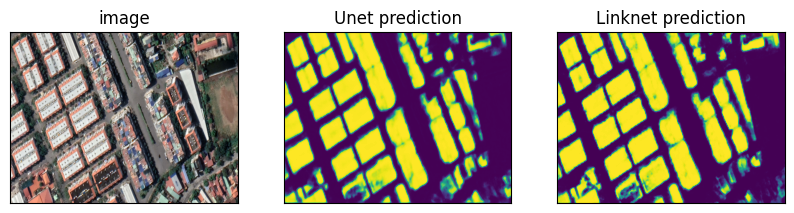

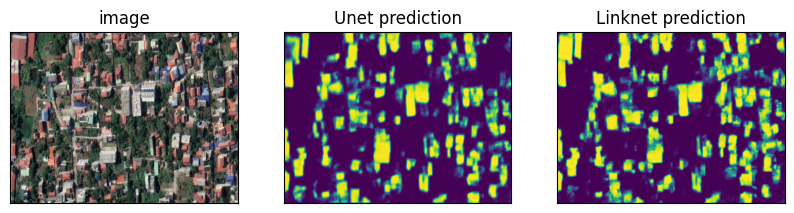

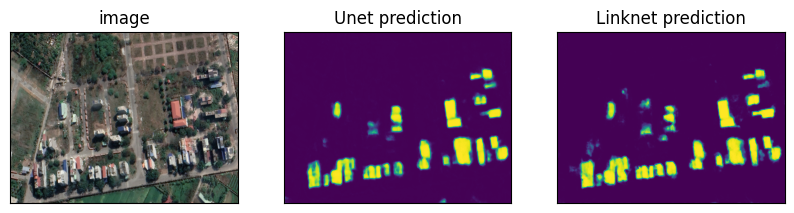

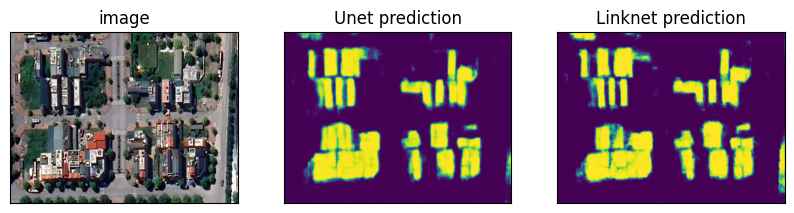

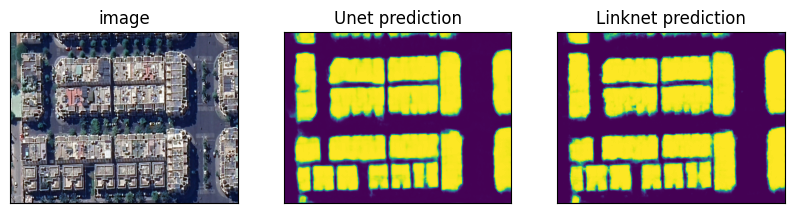

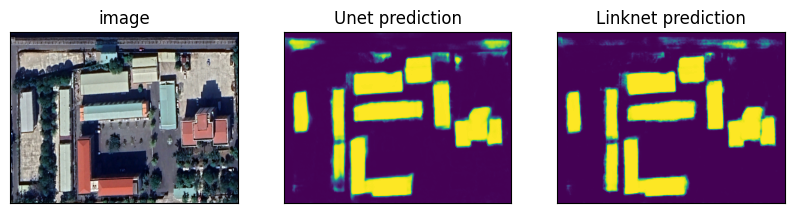

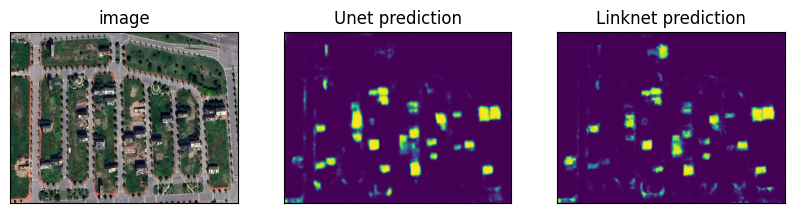

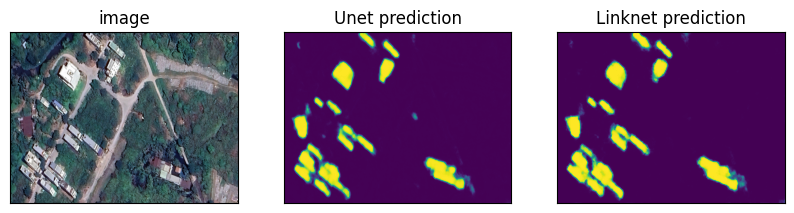

In [ ]:
unet_preds = unet_model.predict(final_val_imgs)
linknet_preds = linknet_model.predict(final_val_imgs)

for i in range(len(final_val_imgs)):
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    final_val_imgs[i]=final_val_imgs[i][...,::-1]
    plt.imshow(final_val_imgs[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('image')
    plt.subplot(1,3,2)
    plt.imshow(unet_preds[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('Unet prediction')
    plt.subplot(1,3,3)
    plt.imshow(linknet_preds[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('Linknet prediction')
    plt.show()